<a href="https://colab.research.google.com/github/Anarchist1984/SeminarProject/blob/main/t1_query_chembl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial has been adapted from the [TeachOpenCADD](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T001_query_chembl/talktorial.ipynb) initiative and the Python notebooks provided by [Ash100](https://github.com/Ash100/CADD_Project/blob/main/Drug_Designing_Project_Part_1.ipynb).

In [ ]:
#@title Download Packages
#@markdown This is where we download all the necessary packages we need. As we are using Google Colab not all of the packages we are using will need to be downloaded and some will already be ready
! pip install chembl_webresource_client --quiet
! pip install rdkit-pypi --quiet
print("Packages downloaded successfully")

Packages downloaded successfully


In [ ]:
#@title Import Packages
#@markdown Ignore the PandasTools error
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [ ]:
#@title Create clients and paths
#@markdown Here we set the paths to where we want to store our data and create the client APIs from which we will be requesting our data
HERE = Path(_dh[-1])
DATA = HERE / "data"
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity
type(targets_api)

chembl_webresource_client.query_set.QuerySet

In [ ]:
#@title Set Target Protein
#@markdown Here we set the target protein to what we want it to be. The default will be the the protein Matrix metalloproteinase 9.
uniprot_id = "P14780" #@param {type:"string"}

In [ ]:
#@title Request data
#@markdown Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)


targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Matrix metalloproteinase 9,CHEMBL321,SINGLE PROTEIN
1,Homo sapiens,Matrix metalloproteinase 9,CHEMBL321,SINGLE PROTEIN
2,Homo sapiens,Collagenase,CHEMBL2095216,PROTEIN FAMILY
3,Homo sapiens,Matrix metalloproteinase 2/9,CHEMBL3885505,PROTEIN FAMILY
4,Homo sapiens,MMP-2/MMP-9,CHEMBL4523972,SELECTIVITY GROUP


In [ ]:
#@title Choose our ChemBL Target
#@markdown We then choose the target we want fromt the ChemBL dataframe above. Since we want Matric Metalloproteinase 9 in the human species, we choose the entry with index 0.

target_id = 0 #@param {type:"integer"}
target = targets.iloc[target_id]
target
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")

The target ChEMBL ID is CHEMBL321


In [ ]:
#@title Find Bioactive Compounds
#@markdown We then find all compounds that seem to be active when used with our protein.
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 2300, <class 'chembl_webresource_client.query_set.QuerySet'>


In [ ]:
#@title Verify Data
#@markdown We then ensure that the data has come through exactly how we predicted.
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]


Length and type of first element: 13, <class 'dict'>


{'activity_id': 33892,
 'assay_chembl_id': 'CHEMBL715225',
 'assay_description': 'In vitro inhibitory activity against matrix metalloprotease-9.',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL80814',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '34.0',
 'target_chembl_id': 'CHEMBL321',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'nM',
 'value': '34.0'}

In [ ]:
#@title Create Dataframe
#@markdown We then make a dataframe with the compounds that we have collected from ChemBL so it is in a manipulatable format.
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (2300, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,33892,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL80814,=,nM,34.0,CHEMBL321,Homo sapiens,IC50,nM,34.0
1,35115,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL276119,=,nM,9.0,CHEMBL321,Homo sapiens,IC50,nM,9.0
2,35120,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78934,=,nM,20.0,CHEMBL321,Homo sapiens,IC50,nM,20.0
3,35125,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78369,=,nM,3.0,CHEMBL321,Homo sapiens,IC50,nM,3.0
4,35129,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL514138,=,nM,9.0,CHEMBL321,Homo sapiens,IC50,nM,9.0


In [ ]:
#@title Units
#@markdown Since many researcher use different units, we want to verify what kind of units we are using before we use them in our project.
bioactivities_df["units"].unique()
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,33892,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL80814,=,nM,34.0,CHEMBL321,Homo sapiens,IC50
1,35115,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL276119,=,nM,9.0,CHEMBL321,Homo sapiens,IC50
2,35120,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78934,=,nM,20.0,CHEMBL321,Homo sapiens,IC50
3,35125,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78369,=,nM,3.0,CHEMBL321,Homo sapiens,IC50
4,35129,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL514138,=,nM,9.0,CHEMBL321,Homo sapiens,IC50


In [ ]:
#@title Convert datatype of "standard_value" from "object" to "float"
#@markdown The field 'standard_value' holds standardized (here IC50) values. In order to make these values usable in calculations later on, convert values to floats.
bioactivities_df.dtypes
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

,0
activity_id,int64
assay_chembl_id,object
assay_description,object
assay_type,object
molecule_chembl_id,object
relation,object
standard_units,object
standard_value,float64
target_chembl_id,object
target_organism,object


In [ ]:
#@title Delete Entries with Missing Values
#@markdown Use the parameter ```inplace=True``` to drop values in the current DataFrame directly.
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (2300, 11)


In [ ]:
#@title Keep only entries with "standard_unit == nM"
#@markdown We only want to keep bioactivity entries in ```nM```, thus we remove all entries with other units.
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")
print(f"DataFrame shape: {bioactivities_df.shape}")

Units in downloaded data: ['nM' 'ug.mL-1']
Number of non-nM entries:    5
Units after filtering: ['nM']
DataFrame shape: (2295, 11)


In [ ]:
#@title Drop Duplicates
#@markdown Sometimes the same molecule (molecule_chembl_id) has been tested more than once, in this case, we only keep the first one.
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (2034, 11)


<ipython-input-80-480920167be3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)


In [ ]:
#@title Reset Index
#@markdown Since we deleted some rows, but we want to iterate over the index later, we reset the index to be continuous.
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,33892,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL80814,=,nM,34.0,CHEMBL321,Homo sapiens,IC50
1,35115,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL276119,=,nM,9.0,CHEMBL321,Homo sapiens,IC50
2,35120,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78934,=,nM,20.0,CHEMBL321,Homo sapiens,IC50
3,35125,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78369,=,nM,3.0,CHEMBL321,Homo sapiens,IC50
4,35129,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL514138,=,nM,9.0,CHEMBL321,Homo sapiens,IC50


In [ ]:
#@title Rename Columns
#@markdown Since some of these columns have long and unfriendly names, we will rename them to make them easier to use in the future
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

<ipython-input-82-723060971ddf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bioactivities_df.rename(


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,33892,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL80814,=,nM,34.0,CHEMBL321,Homo sapiens,IC50
1,35115,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL276119,=,nM,9.0,CHEMBL321,Homo sapiens,IC50
2,35120,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78934,=,nM,20.0,CHEMBL321,Homo sapiens,IC50
3,35125,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL78369,=,nM,3.0,CHEMBL321,Homo sapiens,IC50
4,35129,CHEMBL715225,In vitro inhibitory activity against matrix me...,B,CHEMBL514138,=,nM,9.0,CHEMBL321,Homo sapiens,IC50


In [ ]:
#@title Verify Dataset
#@markdown You should see how many compounds you have left after going through all of our filtering.
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (2034, 11)


In [ ]:
#@title Download our Data from ChemBL
#@markdown Now that we have our bioactive compounds lets download the structure from ChemBL in order to play around with it.
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")
compounds = list(tqdm(compounds_provider))
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

  0%|          | 0/2034 [00:00<?, ?it/s]

DataFrame shape: (2034, 2)


In [ ]:
#@title Let's see our dataset
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL2,{'canonical_smiles': 'COc1cc2nc(N3CCN(C(=O)c4c...
1,CHEMBL268377,{'canonical_smiles': 'COc1ccc(S(=O)(=O)N2CN(C(...
2,CHEMBL7108,{'canonical_smiles': 'COc1ccc(S(=O)(=O)N2CN(C(...
3,CHEMBL267939,{'canonical_smiles': 'COc1ccc(S(=O)(=O)N2CCN(C...
4,CHEMBL415482,{'canonical_smiles': 'COc1ccc(S(=O)(=O)N2CCN(C...


In [ ]:
#@title Drop Duplicates
#@markdown We follow many of the same steps as processing our original data and exclude any duplicate and non-existent values
compounds_df.dropna(axis=0, how="any", inplace=True)
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2034, 2)


In [ ]:
#@title Keep SMILES
#@markdown Now lets only keep the smiles of the the dataset as that is the only real thing we are interesting in as SMILES shows the structure of our molecule.
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2034, 2)


In [ ]:
#@title Check both of our datasets
#@markdown We then check both of our datasets to see how many entires we have in each and merge them to create our final dataset.
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
print(f"Compounds filtered: {compounds_df.shape[0]}")
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset merged with final entry count of{output_df.shape[0]}.")

Bioactivities filtered: 2034
Compounds filtered: 2034
Dataset merged with final entry count of2034.


In [ ]:
#@title Check data values
#@markdown We then check that all of oru data is in the correct format.
output_df.dtypes

,0
molecule_chembl_id,object
IC50,float64
units,object
smiles,object


In [ ]:
#@title Check first 10 Rows
#@markdown We then look at the first 10 rows to ensure everything came through how we expected it to.
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL80814,34.0,nM,COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3...
1,CHEMBL276119,9.0,nM,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)...
2,CHEMBL78934,20.0,nM,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c...
3,CHEMBL78369,3.0,nM,O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc...
4,CHEMBL514138,9.0,nM,COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(...
5,CHEMBL80453,44.0,nM,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(CCCOc3ccccc3)C...
6,CHEMBL312432,6.0,nM,Cc1ccc(CN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OCc4ccc(...
7,CHEMBL306617,5.0,nM,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(CCOc3ccccc3...
8,CHEMBL79111,43.0,nM,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(CC)CC2)cc1
9,CHEMBL78798,2.0,nM,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(OCCN...


In [ ]:
#@title Convert to pIC50
#@markdown Since IC50 scales too fast, we use a logarithmic scale of pIC50 to ensure that our data is the appropriate size for a machine learning model.
def convert_ic50_to_pic50(IC50_value):
    """
    Converts IC50 values to pIC50 values.
    Handles invalid IC50 values by returning NaN.
    """
    try:
        # Attempt to calculate pIC50 if IC50 is positive
        if IC50_value > 0:
            pIC50_value = 9 - math.log10(IC50_value)
            return pIC50_value
        else:
            # Return NaN for non-positive IC50 values
            return float('nan')
    except ValueError:
        # Return NaN if any other ValueError occurs
        return float('nan')

output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL80814,34.0,nM,COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3...,7.468521
1,CHEMBL276119,9.0,nM,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)...,8.045757
2,CHEMBL78934,20.0,nM,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c...,7.698970
3,CHEMBL78369,3.0,nM,O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc...,8.522879
4,CHEMBL514138,9.0,nM,COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(...,8.045757


array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

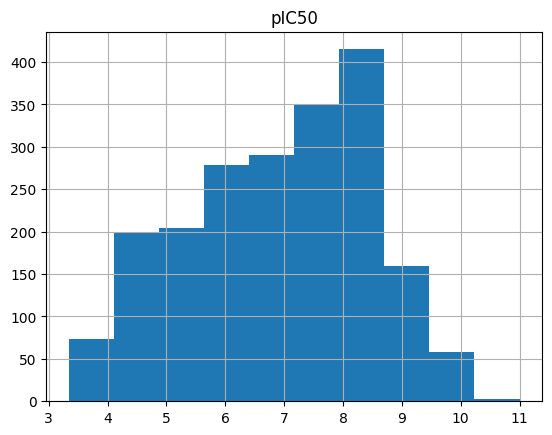

In [ ]:
output_df.hist(column="pIC50")

In [ ]:
#@title Show the most active molecules
#@markdown We want to look at the most active molecules what they are just to make sure everything is working
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)
output_df.drop("smiles", axis=1).head(3)

Failed to patch pandas - unable to change molecule rendering


,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL323090,0.01,nM,11.000000,<rdkit.Chem.rdchem.Mol object at 0x7b261929a260>
1,CHEMBL2064547,0.03,nM,10.522879,<rdkit.Chem.rdchem.Mol object at 0x7b26192b2ab0>
2,CHEMBL2064549,0.05,nM,10.301030,<rdkit.Chem.rdchem.Mol object at 0x7b26192b2b90>


In [ ]:
#@title Prepare for Saving Data
#@markdown Save the processed dataset for use in other applications

import os

# Drop the "ROMol" column before saving the dataset
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape after dropping 'ROMol': {output_df.shape}")

# Create a folder named "data" if it doesn't already exist
current_dir = os.getcwd()
data_folder = os.path.join(current_dir, "data")
os.makedirs(data_folder, exist_ok=True)
print(f"'data' folder created at: {data_folder}")

# Save the dataset as a CSV file in the "data" folder
output_path = os.path.join(data_folder, "MMP9-Inhibitor_Compounds.csv")
output_df.to_csv(output_path, index=False)
print(f"Dataset saved to: {output_path}")

# Display the first few rows of the dataset for verification
output_df.head()


DataFrame shape after dropping 'ROMol': (2034, 5)
'data' folder created at: /content/data
Dataset saved to: /content/data/MMP9-Inhibitor_Compounds.csv


,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL323090,0.01,nM,COc1ccc(S(=O)(=O)N(CC(=O)NCC2CCCCC2)C(CCSCc2cc...,11.000000
1,CHEMBL2064547,0.03,nM,COc1ccc(S(=O)(=O)N(Cc2cn(CCF)nn2)[C@@H](C(=O)N...,10.522879
2,CHEMBL2064549,0.05,nM,COc1ccc(S(=O)(=O)N(Cc2cn(CCOCCOCCOCCF)nn2)[C@@...,10.301030
3,CHEMBL2064548,0.06,nM,COc1ccc(S(=O)(=O)N(Cc2cn(CCOCCOCCOCCOS(=O)(=O)...,10.221849
4,CHEMBL2425947,0.07,nM,COc1ccc(S(=O)(=O)N(CCn2cc(CCCF)nn2)[C@@H](C(=O...,10.154902


In [ ]:
#@title Save to Google Drive
#@markdown This is a strictly optional step where we save the data to a google drive folder and it suggested if your are using Google Colab/
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/Mathew_AP_Seminar/Research Project/Data' #@param {type:"string"}
output_df.to_csv(f'{folder_path}/MMP9-Inhibitor_Compounds.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
